# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-59p2lmww
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-59p2lmww
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


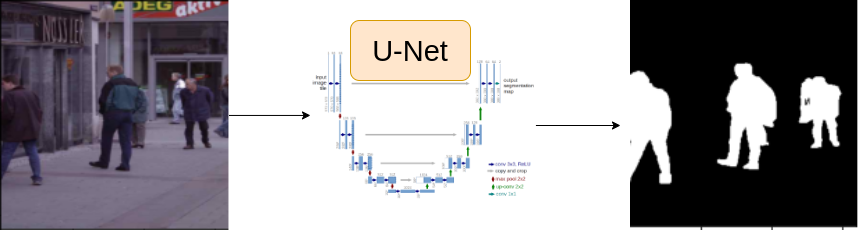

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from torch.utils.data import Dataset, DataLoader
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

import albumentations as A

from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Task : 2 Setup Configurations

In [5]:
def show_image(image,mask,pred_image = None):
    
    if pred_image == None:
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
        ax1.set_title('Input Image')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        ax1.axis('off')
        
        ax2.set_title('GT Mask')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        ax2.axis('off')
        
    elif pred_image != None :
        
        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))
        
        ax1.set_title('Input Image')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        ax1.axis('off')

        ax2.set_title('GT Mask')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        ax2.axis('off')
        
        ax3.set_title('Predicted Mask')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')
        ax3.axis('off')

In [6]:
CSV_FILE = "/content/Human-Segmentation-Dataset-master/train.csv"
DATA_DIR = "/content/"
DEVICE = "cuda"
EPOCHS = 225
LR = 0.003
BATCH_SIZE=16
IMAGE_SIZE=320
ENCODER="timm-mobilenetv3_large_100"
WEIGHTS='imagenet'

# See data
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


Input image shape: (183, 276, 3)
GT mask shape: (183, 276)
Input image shape: (183, 275, 3)
GT mask shape: (183, 275)


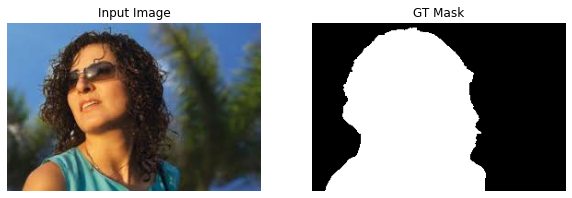

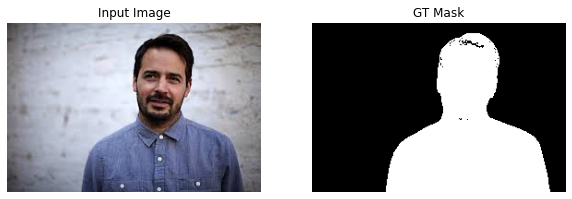

In [7]:
def check_data(df):
  for i in range(len(df)):
    if i == 2:
      break
    row = df.iloc[i]
    image_path = row.images
    mask_path = row.masks
    image=cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    mask=cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    print(f"Input image shape: {image.shape}")
    print(f"GT mask shape: {mask.shape}")
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.set_title('Input Image')
    ax1.imshow(image)
    ax1.axis('off')

    ax2.set_title('GT Mask')
    ax2.imshow(mask,cmap = 'gray')
    ax2.axis('off')

check_data(df)

In [8]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [9]:
def get_train_augs():

  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])

def get_valid_augs():

  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
  ])

def get_imgs_and_masks(row):
  
  image_path = row.images
  mask_path = row.masks
  image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
  mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
  image = cv2.resize(image, (IMAGE_SIZE,IMAGE_SIZE))
  mask = np.expand_dims(cv2.resize(mask, (IMAGE_SIZE,IMAGE_SIZE)), axis=-1)

  return image, mask

# Task 4 : Create Custom Dataset 

In [10]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):

    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]
    image, mask = get_imgs_and_masks(row)
    # print(image.shape)
    # print(mask.shape)

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask)
      image = data['image']
      mask = data['mask']

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)
    # print(image.shape)
    # print(mask.shape)

    image = torch.Tensor(image) / 255.
    mask = torch.round(torch.Tensor(mask) / 255.)

    return image, mask

In [11]:
trainset = SegmentationDataset(df=train_df, augmentations=get_train_augs())
validset = SegmentationDataset(df=valid_df, augmentations=get_valid_augs())

In [12]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


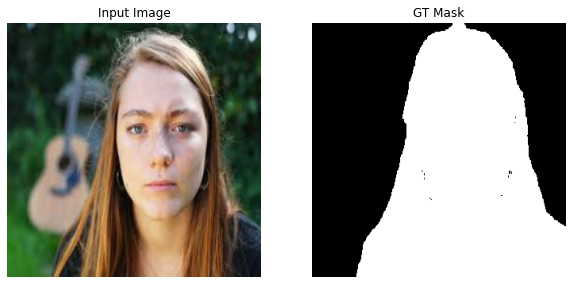

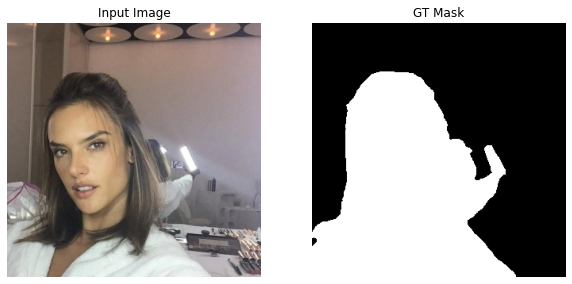

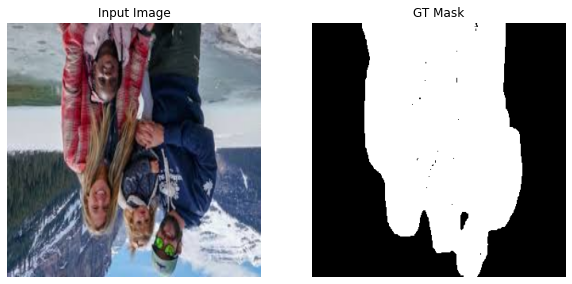

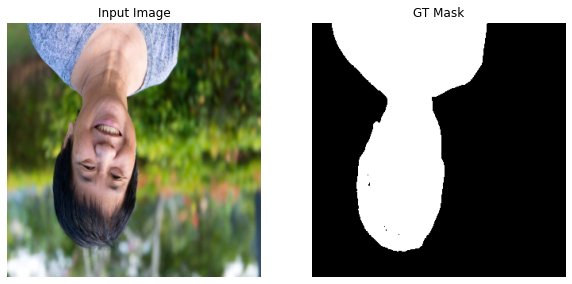

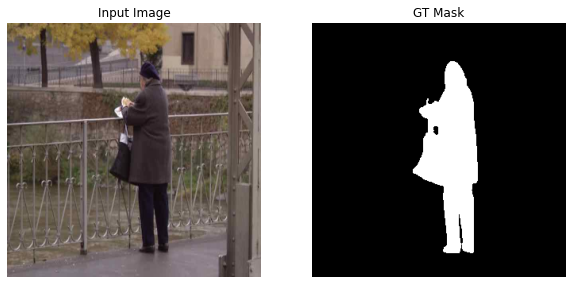

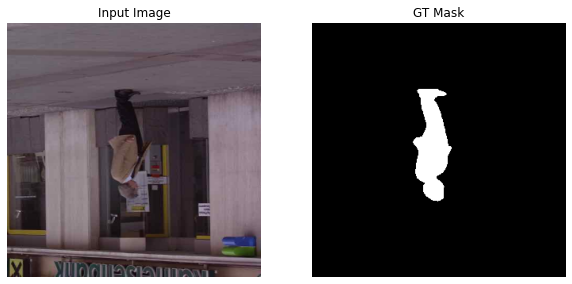

In [13]:
def check_ds(ds):
  for idx, (img, mask) in enumerate(ds):
    show_image(img, mask)
    if idx == 5:
      break
check_ds(trainset)

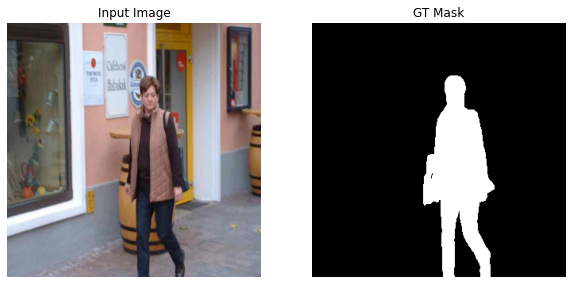

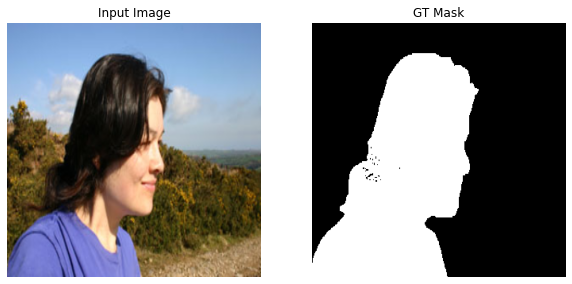

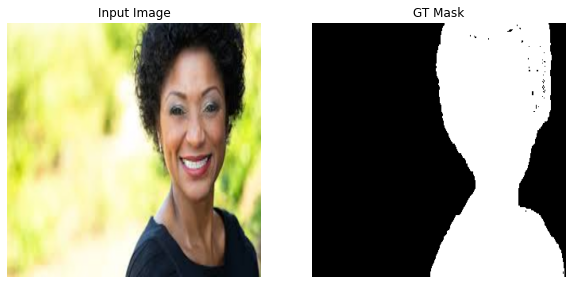

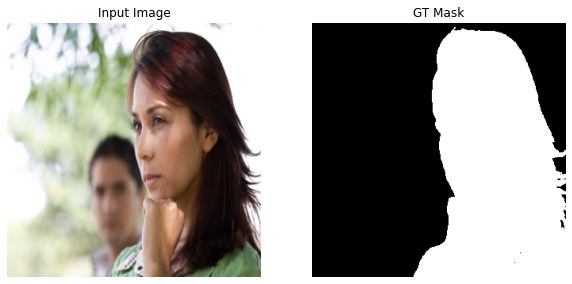

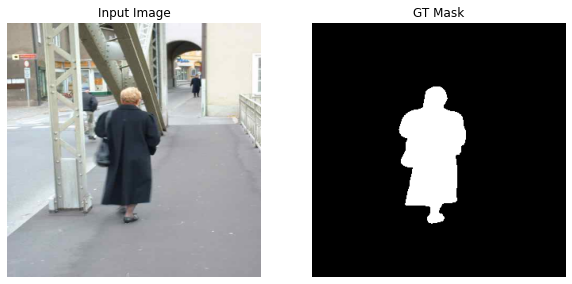

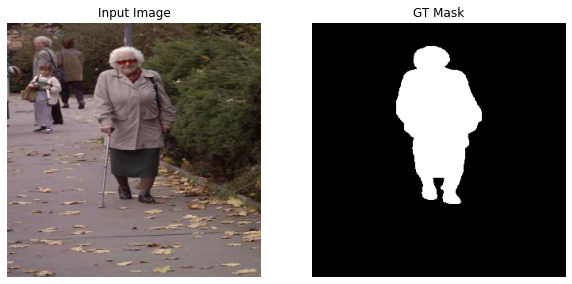

In [14]:
check_ds(validset)

# Task 5 : Load dataset into batches

In [15]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False)
print(f"Number of batches in the trainloader: {len(trainloader)}")
print(f"Number of batches in the validloader: {len(validloader)}")

Number of batches in the trainloader: 15
Number of batches in the validloader: 4


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [16]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3,
        classes=1,
        activation=None
    )

  def forward(self, images, masks=None):
    
    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)

      return logits, loss1+loss2

    return logits

In [17]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_mobilenetv3_large_100-427764d5.pth" to /root/.cache/torch/hub/checkpoints/tf_mobilenetv3_large_100-427764d5.pth


  0%|          | 0.00/21.1M [00:00<?, ?B/s]

SegmentationModel(
  (arc): Unet(
    (encoder): MobileNetV3Encoder(
      (model): MobileNetV3Features(
        (conv_stem): Conv2dSame(3, 16, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn1): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): Hardswish()
        (blocks): Sequential(
          (0): Sequential(
            (0): DepthwiseSeparableConv(
              (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
              (bn1): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (act1): ReLU(inplace=True)
              (se): Identity()
              (conv_pw): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (act2): Identity()
            )
          )
          (1): Sequential(
            (0): InvertedRe

# Task 7 : Create Train and Validation Function 

In [18]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [19]:
def eval_fn(data_loader, model):

  model.eval()
  total_loss = 0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      optimizer.zero_grad()
      logits, loss = model(images, masks)

      total_loss += loss.item()

  return total_loss / len(data_loader)

# Task 8 : Train Model

In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
best_valid_loss = np.Inf

for epoch in range(EPOCHS):

  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'best_model.pt')
    print("Best model is saved!")

  print(f"Epoch {epoch+1} is completed!")
  print(f"Train loss: {train_loss:.3f}")
  print(f"Validation loss: {valid_loss:.3f}")

100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


Best model is saved!
Epoch 1 is completed!
Train loss: 0.808
Validation loss: 1.228


100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


Best model is saved!
Epoch 2 is completed!
Train loss: 0.378
Validation loss: 0.589


100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


Epoch 3 is completed!
Train loss: 0.294
Validation loss: 0.730


100%|██████████| 4/4 [00:00<00:00,  5.34it/s]


Best model is saved!
Epoch 4 is completed!
Train loss: 0.228
Validation loss: 0.240


100%|██████████| 4/4 [00:00<00:00,  5.27it/s]


Best model is saved!
Epoch 5 is completed!
Train loss: 0.217
Validation loss: 0.182


100%|██████████| 4/4 [00:01<00:00,  3.99it/s]


Best model is saved!
Epoch 6 is completed!
Train loss: 0.163
Validation loss: 0.168


100%|██████████| 4/4 [00:00<00:00,  5.32it/s]


Epoch 7 is completed!
Train loss: 0.151
Validation loss: 0.184


100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


Epoch 8 is completed!
Train loss: 0.162
Validation loss: 0.223


100%|██████████| 4/4 [00:00<00:00,  5.46it/s]


Epoch 9 is completed!
Train loss: 0.153
Validation loss: 0.295


100%|██████████| 4/4 [00:00<00:00,  5.38it/s]


Epoch 10 is completed!
Train loss: 0.157
Validation loss: 0.213


100%|██████████| 4/4 [00:01<00:00,  3.64it/s]


Epoch 11 is completed!
Train loss: 0.144
Validation loss: 0.293


100%|██████████| 4/4 [00:00<00:00,  5.45it/s]


Epoch 12 is completed!
Train loss: 0.148
Validation loss: 0.363


100%|██████████| 4/4 [00:00<00:00,  5.45it/s]


Epoch 13 is completed!
Train loss: 0.121
Validation loss: 0.198


100%|██████████| 4/4 [00:00<00:00,  5.23it/s]


Epoch 14 is completed!
Train loss: 0.126
Validation loss: 0.180


100%|██████████| 4/4 [00:00<00:00,  5.37it/s]


Epoch 15 is completed!
Train loss: 0.133
Validation loss: 0.245


100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


Epoch 16 is completed!
Train loss: 0.166
Validation loss: 0.225


100%|██████████| 4/4 [00:00<00:00,  5.49it/s]


Epoch 17 is completed!
Train loss: 0.152
Validation loss: 0.180


100%|██████████| 4/4 [00:00<00:00,  5.30it/s]


Epoch 18 is completed!
Train loss: 0.122
Validation loss: 0.210


100%|██████████| 4/4 [00:00<00:00,  5.36it/s]


Epoch 19 is completed!
Train loss: 0.111
Validation loss: 0.195


100%|██████████| 4/4 [00:00<00:00,  5.48it/s]


Epoch 20 is completed!
Train loss: 0.109
Validation loss: 0.183


100%|██████████| 4/4 [00:00<00:00,  5.36it/s]


Epoch 21 is completed!
Train loss: 0.096
Validation loss: 0.182


100%|██████████| 4/4 [00:00<00:00,  5.45it/s]


Best model is saved!
Epoch 22 is completed!
Train loss: 0.085
Validation loss: 0.143


100%|██████████| 4/4 [00:00<00:00,  5.38it/s]


Epoch 23 is completed!
Train loss: 0.079
Validation loss: 0.160


100%|██████████| 4/4 [00:00<00:00,  5.46it/s]


Epoch 24 is completed!
Train loss: 0.106
Validation loss: 0.198


100%|██████████| 4/4 [00:00<00:00,  5.45it/s]


Epoch 25 is completed!
Train loss: 0.092
Validation loss: 0.193


100%|██████████| 4/4 [00:00<00:00,  5.42it/s]


Epoch 26 is completed!
Train loss: 0.096
Validation loss: 0.203


100%|██████████| 4/4 [00:00<00:00,  5.47it/s]


Epoch 27 is completed!
Train loss: 0.080
Validation loss: 0.223


100%|██████████| 4/4 [00:00<00:00,  5.48it/s]


Epoch 28 is completed!
Train loss: 0.098
Validation loss: 0.213


100%|██████████| 4/4 [00:00<00:00,  5.33it/s]


Epoch 29 is completed!
Train loss: 0.093
Validation loss: 0.246


100%|██████████| 4/4 [00:00<00:00,  5.29it/s]


Epoch 30 is completed!
Train loss: 0.093
Validation loss: 0.293


100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


Epoch 31 is completed!
Train loss: 0.112
Validation loss: 0.353


100%|██████████| 4/4 [00:00<00:00,  5.48it/s]


Epoch 32 is completed!
Train loss: 0.133
Validation loss: 0.386


100%|██████████| 4/4 [00:00<00:00,  5.47it/s]


Epoch 33 is completed!
Train loss: 0.156
Validation loss: 0.258


100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


Epoch 34 is completed!
Train loss: 0.120
Validation loss: 0.243


100%|██████████| 4/4 [00:00<00:00,  5.48it/s]


Epoch 35 is completed!
Train loss: 0.105
Validation loss: 0.244


100%|██████████| 4/4 [00:00<00:00,  5.51it/s]


Epoch 36 is completed!
Train loss: 0.103
Validation loss: 0.167


100%|██████████| 4/4 [00:00<00:00,  5.51it/s]


Epoch 37 is completed!
Train loss: 0.093
Validation loss: 0.164


100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


Epoch 38 is completed!
Train loss: 0.086
Validation loss: 0.188


100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


Epoch 39 is completed!
Train loss: 0.073
Validation loss: 0.205


100%|██████████| 4/4 [00:00<00:00,  5.49it/s]


Epoch 40 is completed!
Train loss: 0.066
Validation loss: 0.169


100%|██████████| 4/4 [00:00<00:00,  5.51it/s]


Epoch 41 is completed!
Train loss: 0.061
Validation loss: 0.162


100%|██████████| 4/4 [00:00<00:00,  5.44it/s]


Epoch 42 is completed!
Train loss: 0.067
Validation loss: 0.174


100%|██████████| 4/4 [00:00<00:00,  5.29it/s]


Epoch 43 is completed!
Train loss: 0.061
Validation loss: 0.220


100%|██████████| 4/4 [00:00<00:00,  5.38it/s]


Epoch 44 is completed!
Train loss: 0.081
Validation loss: 0.305


100%|██████████| 4/4 [00:00<00:00,  5.49it/s]


Epoch 45 is completed!
Train loss: 0.175
Validation loss: 0.620


100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


Epoch 46 is completed!
Train loss: 0.146
Validation loss: 0.252


100%|██████████| 4/4 [00:00<00:00,  5.51it/s]


Epoch 47 is completed!
Train loss: 0.120
Validation loss: 0.232


100%|██████████| 4/4 [00:00<00:00,  5.34it/s]


Epoch 48 is completed!
Train loss: 0.101
Validation loss: 0.206


100%|██████████| 4/4 [00:00<00:00,  5.43it/s]


Epoch 49 is completed!
Train loss: 0.091
Validation loss: 0.181


100%|██████████| 4/4 [00:00<00:00,  5.36it/s]


Epoch 50 is completed!
Train loss: 0.080
Validation loss: 0.192


100%|██████████| 4/4 [00:00<00:00,  5.44it/s]


Epoch 51 is completed!
Train loss: 0.074
Validation loss: 0.209


100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


Epoch 52 is completed!
Train loss: 0.072
Validation loss: 0.183


100%|██████████| 4/4 [00:00<00:00,  5.35it/s]


Epoch 53 is completed!
Train loss: 0.064
Validation loss: 0.184


100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


Epoch 54 is completed!
Train loss: 0.066
Validation loss: 0.186


100%|██████████| 4/4 [00:00<00:00,  5.44it/s]


Epoch 55 is completed!
Train loss: 0.068
Validation loss: 0.170


100%|██████████| 4/4 [00:00<00:00,  5.51it/s]


Epoch 56 is completed!
Train loss: 0.066
Validation loss: 0.223


100%|██████████| 4/4 [00:00<00:00,  5.46it/s]


Epoch 57 is completed!
Train loss: 0.061
Validation loss: 0.190


100%|██████████| 4/4 [00:00<00:00,  5.39it/s]


Epoch 58 is completed!
Train loss: 0.058
Validation loss: 0.171


100%|██████████| 4/4 [00:00<00:00,  5.41it/s]


Epoch 59 is completed!
Train loss: 0.054
Validation loss: 0.175


100%|██████████| 4/4 [00:00<00:00,  5.40it/s]


Epoch 60 is completed!
Train loss: 0.054
Validation loss: 0.172


100%|██████████| 4/4 [00:00<00:00,  5.49it/s]


Epoch 61 is completed!
Train loss: 0.054
Validation loss: 0.168


100%|██████████| 4/4 [00:00<00:00,  5.42it/s]


Epoch 62 is completed!
Train loss: 0.049
Validation loss: 0.162


100%|██████████| 4/4 [00:00<00:00,  5.18it/s]


Epoch 63 is completed!
Train loss: 0.048
Validation loss: 0.158


100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


Epoch 64 is completed!
Train loss: 0.048
Validation loss: 0.155


100%|██████████| 4/4 [00:00<00:00,  5.47it/s]


Epoch 65 is completed!
Train loss: 0.046
Validation loss: 0.160


100%|██████████| 4/4 [00:00<00:00,  5.48it/s]


Epoch 66 is completed!
Train loss: 0.046
Validation loss: 0.170


100%|██████████| 4/4 [00:00<00:00,  5.39it/s]


Epoch 67 is completed!
Train loss: 0.045
Validation loss: 0.165


100%|██████████| 4/4 [00:00<00:00,  5.46it/s]


Epoch 68 is completed!
Train loss: 0.045
Validation loss: 0.167


100%|██████████| 4/4 [00:00<00:00,  5.41it/s]


Epoch 69 is completed!
Train loss: 0.043
Validation loss: 0.168


100%|██████████| 4/4 [00:00<00:00,  5.47it/s]


Epoch 70 is completed!
Train loss: 0.044
Validation loss: 0.161


100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


Epoch 71 is completed!
Train loss: 0.042
Validation loss: 0.165


100%|██████████| 4/4 [00:00<00:00,  5.37it/s]


Epoch 72 is completed!
Train loss: 0.044
Validation loss: 0.168


100%|██████████| 4/4 [00:00<00:00,  5.43it/s]


Epoch 73 is completed!
Train loss: 0.045
Validation loss: 0.229


100%|██████████| 4/4 [00:00<00:00,  5.32it/s]


Epoch 74 is completed!
Train loss: 0.043
Validation loss: 0.171


100%|██████████| 4/4 [00:00<00:00,  4.72it/s]


Epoch 75 is completed!
Train loss: 0.042
Validation loss: 0.167


100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


Epoch 76 is completed!
Train loss: 0.041
Validation loss: 0.170


100%|██████████| 4/4 [00:00<00:00,  5.35it/s]


Epoch 77 is completed!
Train loss: 0.041
Validation loss: 0.171


100%|██████████| 4/4 [00:00<00:00,  5.45it/s]


Epoch 78 is completed!
Train loss: 0.040
Validation loss: 0.167


100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


Epoch 79 is completed!
Train loss: 0.040
Validation loss: 0.170


100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


Epoch 80 is completed!
Train loss: 0.039
Validation loss: 0.173


100%|██████████| 4/4 [00:00<00:00,  5.45it/s]


Epoch 81 is completed!
Train loss: 0.039
Validation loss: 0.176


100%|██████████| 4/4 [00:00<00:00,  5.45it/s]


Epoch 82 is completed!
Train loss: 0.039
Validation loss: 0.167


100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


Epoch 83 is completed!
Train loss: 0.038
Validation loss: 0.170


100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


Epoch 84 is completed!
Train loss: 0.038
Validation loss: 0.174


100%|██████████| 4/4 [00:00<00:00,  5.47it/s]


Epoch 85 is completed!
Train loss: 0.039
Validation loss: 0.178


100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


Epoch 86 is completed!
Train loss: 0.037
Validation loss: 0.179


100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


Epoch 87 is completed!
Train loss: 0.039
Validation loss: 0.179


100%|██████████| 4/4 [00:00<00:00,  5.46it/s]


Epoch 88 is completed!
Train loss: 0.040
Validation loss: 0.189


100%|██████████| 4/4 [00:00<00:00,  5.46it/s]


Epoch 89 is completed!
Train loss: 0.038
Validation loss: 0.188


100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


Epoch 90 is completed!
Train loss: 0.037
Validation loss: 0.188


100%|██████████| 4/4 [00:00<00:00,  5.40it/s]


Epoch 91 is completed!
Train loss: 0.037
Validation loss: 0.179


100%|██████████| 4/4 [00:00<00:00,  5.38it/s]


Epoch 92 is completed!
Train loss: 0.037
Validation loss: 0.180


100%|██████████| 4/4 [00:00<00:00,  5.48it/s]


Epoch 93 is completed!
Train loss: 0.037
Validation loss: 0.190


100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


Epoch 94 is completed!
Train loss: 0.037
Validation loss: 0.179


100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


Epoch 95 is completed!
Train loss: 0.036
Validation loss: 0.172


100%|██████████| 4/4 [00:00<00:00,  5.49it/s]


Epoch 96 is completed!
Train loss: 0.035
Validation loss: 0.183


100%|██████████| 4/4 [00:00<00:00,  5.41it/s]


Epoch 97 is completed!
Train loss: 0.035
Validation loss: 0.176


100%|██████████| 4/4 [00:00<00:00,  5.42it/s]


Epoch 98 is completed!
Train loss: 0.035
Validation loss: 0.175


100%|██████████| 4/4 [00:00<00:00,  5.39it/s]


Epoch 99 is completed!
Train loss: 0.034
Validation loss: 0.181


100%|██████████| 4/4 [00:00<00:00,  5.42it/s]


Epoch 100 is completed!
Train loss: 0.034
Validation loss: 0.181


100%|██████████| 4/4 [00:00<00:00,  5.49it/s]


Epoch 101 is completed!
Train loss: 0.035
Validation loss: 0.181


100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


Epoch 102 is completed!
Train loss: 0.035
Validation loss: 0.188


100%|██████████| 4/4 [00:00<00:00,  5.37it/s]


Epoch 103 is completed!
Train loss: 0.034
Validation loss: 0.178


100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


Epoch 104 is completed!
Train loss: 0.032
Validation loss: 0.173


100%|██████████| 4/4 [00:00<00:00,  5.30it/s]


Epoch 105 is completed!
Train loss: 0.034
Validation loss: 0.186


100%|██████████| 4/4 [00:00<00:00,  5.48it/s]


Epoch 106 is completed!
Train loss: 0.034
Validation loss: 0.171


100%|██████████| 4/4 [00:00<00:00,  5.48it/s]


Epoch 107 is completed!
Train loss: 0.032
Validation loss: 0.173


100%|██████████| 4/4 [00:00<00:00,  5.49it/s]


Epoch 108 is completed!
Train loss: 0.034
Validation loss: 0.176


100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


Epoch 109 is completed!
Train loss: 0.034
Validation loss: 0.171


100%|██████████| 4/4 [00:00<00:00,  5.35it/s]


Epoch 110 is completed!
Train loss: 0.034
Validation loss: 0.181


100%|██████████| 4/4 [00:00<00:00,  5.35it/s]


Epoch 111 is completed!
Train loss: 0.033
Validation loss: 0.179


100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


Epoch 112 is completed!
Train loss: 0.032
Validation loss: 0.177


100%|██████████| 4/4 [00:00<00:00,  5.32it/s]


Epoch 113 is completed!
Train loss: 0.033
Validation loss: 0.176


100%|██████████| 4/4 [00:00<00:00,  5.58it/s]


Epoch 114 is completed!
Train loss: 0.032
Validation loss: 0.164


100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


Epoch 115 is completed!
Train loss: 0.032
Validation loss: 0.166


100%|██████████| 4/4 [00:00<00:00,  5.48it/s]


Epoch 116 is completed!
Train loss: 0.032
Validation loss: 0.167


100%|██████████| 4/4 [00:00<00:00,  5.44it/s]


Epoch 117 is completed!
Train loss: 0.032
Validation loss: 0.178


100%|██████████| 4/4 [00:00<00:00,  5.57it/s]


Epoch 118 is completed!
Train loss: 0.033
Validation loss: 0.179


100%|██████████| 4/4 [00:00<00:00,  5.46it/s]


Epoch 119 is completed!
Train loss: 0.032
Validation loss: 0.169


100%|██████████| 4/4 [00:00<00:00,  5.51it/s]


Epoch 120 is completed!
Train loss: 0.030
Validation loss: 0.184


100%|██████████| 4/4 [00:00<00:00,  5.43it/s]


Epoch 121 is completed!
Train loss: 0.031
Validation loss: 0.187


100%|██████████| 4/4 [00:00<00:00,  5.46it/s]


Epoch 122 is completed!
Train loss: 0.030
Validation loss: 0.186


100%|██████████| 4/4 [00:00<00:00,  5.41it/s]


Epoch 123 is completed!
Train loss: 0.030
Validation loss: 0.197


100%|██████████| 4/4 [00:00<00:00,  5.36it/s]


Epoch 124 is completed!
Train loss: 0.031
Validation loss: 0.189


100%|██████████| 4/4 [00:00<00:00,  5.45it/s]


Epoch 125 is completed!
Train loss: 0.032
Validation loss: 0.198


100%|██████████| 4/4 [00:00<00:00,  5.48it/s]


Epoch 126 is completed!
Train loss: 0.030
Validation loss: 0.168


100%|██████████| 4/4 [00:00<00:00,  5.59it/s]


Epoch 127 is completed!
Train loss: 0.031
Validation loss: 0.184


100%|██████████| 4/4 [00:00<00:00,  5.51it/s]


Epoch 128 is completed!
Train loss: 0.030
Validation loss: 0.185


100%|██████████| 4/4 [00:00<00:00,  5.44it/s]


Epoch 129 is completed!
Train loss: 0.030
Validation loss: 0.191


100%|██████████| 4/4 [00:00<00:00,  5.51it/s]


Epoch 130 is completed!
Train loss: 0.029
Validation loss: 0.190


100%|██████████| 4/4 [00:00<00:00,  5.37it/s]


Epoch 131 is completed!
Train loss: 0.030
Validation loss: 0.186


100%|██████████| 4/4 [00:00<00:00,  5.49it/s]


Epoch 132 is completed!
Train loss: 0.029
Validation loss: 0.189


100%|██████████| 4/4 [00:00<00:00,  5.31it/s]


Epoch 133 is completed!
Train loss: 0.028
Validation loss: 0.184


100%|██████████| 4/4 [00:00<00:00,  5.43it/s]


Epoch 134 is completed!
Train loss: 0.028
Validation loss: 0.184


100%|██████████| 4/4 [00:00<00:00,  5.40it/s]


Epoch 135 is completed!
Train loss: 0.029
Validation loss: 0.183


100%|██████████| 4/4 [00:00<00:00,  5.40it/s]


Epoch 136 is completed!
Train loss: 0.029
Validation loss: 0.188


100%|██████████| 4/4 [00:00<00:00,  5.44it/s]


Epoch 137 is completed!
Train loss: 0.029
Validation loss: 0.190


100%|██████████| 4/4 [00:00<00:00,  5.45it/s]


Epoch 138 is completed!
Train loss: 0.027
Validation loss: 0.190


100%|██████████| 4/4 [00:00<00:00,  5.41it/s]


Epoch 139 is completed!
Train loss: 0.028
Validation loss: 0.200


100%|██████████| 4/4 [00:00<00:00,  5.22it/s]


Epoch 140 is completed!
Train loss: 0.029
Validation loss: 0.193


100%|██████████| 4/4 [00:00<00:00,  5.44it/s]


Epoch 141 is completed!
Train loss: 0.028
Validation loss: 0.190


100%|██████████| 4/4 [00:01<00:00,  3.89it/s]


Epoch 142 is completed!
Train loss: 0.028
Validation loss: 0.206


100%|██████████| 4/4 [00:00<00:00,  5.40it/s]


Epoch 143 is completed!
Train loss: 0.027
Validation loss: 0.226


100%|██████████| 4/4 [00:00<00:00,  5.35it/s]


Epoch 144 is completed!
Train loss: 0.027
Validation loss: 0.207


100%|██████████| 4/4 [00:00<00:00,  5.42it/s]


Epoch 145 is completed!
Train loss: 0.027
Validation loss: 0.213


100%|██████████| 4/4 [00:00<00:00,  5.42it/s]


Epoch 146 is completed!
Train loss: 0.027
Validation loss: 0.205


100%|██████████| 4/4 [00:00<00:00,  5.37it/s]


Epoch 147 is completed!
Train loss: 0.028
Validation loss: 0.211


100%|██████████| 4/4 [00:00<00:00,  5.43it/s]


Epoch 148 is completed!
Train loss: 0.037
Validation loss: 0.243


100%|██████████| 4/4 [00:00<00:00,  5.34it/s]


Epoch 149 is completed!
Train loss: 0.062
Validation loss: 0.363


100%|██████████| 4/4 [00:00<00:00,  5.40it/s]


Epoch 150 is completed!
Train loss: 0.123
Validation loss: 0.584


100%|██████████| 4/4 [00:00<00:00,  5.40it/s]


Epoch 151 is completed!
Train loss: 0.268
Validation loss: 1.887


100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


Epoch 152 is completed!
Train loss: 0.365
Validation loss: 0.700


100%|██████████| 4/4 [00:00<00:00,  5.45it/s]


Epoch 153 is completed!
Train loss: 0.315
Validation loss: 0.543


100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


Epoch 154 is completed!
Train loss: 0.191
Validation loss: 0.242


100%|██████████| 4/4 [00:00<00:00,  5.43it/s]


Epoch 155 is completed!
Train loss: 0.154
Validation loss: 0.188


100%|██████████| 4/4 [00:00<00:00,  5.41it/s]


Epoch 156 is completed!
Train loss: 0.127
Validation loss: 0.172


100%|██████████| 4/4 [00:00<00:00,  5.44it/s]


Epoch 157 is completed!
Train loss: 0.104
Validation loss: 0.166


100%|██████████| 4/4 [00:00<00:00,  5.47it/s]


Epoch 158 is completed!
Train loss: 0.115
Validation loss: 0.225


100%|██████████| 4/4 [00:00<00:00,  5.46it/s]


Epoch 159 is completed!
Train loss: 0.102
Validation loss: 0.273


100%|██████████| 4/4 [00:00<00:00,  5.42it/s]


Epoch 160 is completed!
Train loss: 0.091
Validation loss: 0.220


100%|██████████| 4/4 [00:00<00:00,  5.31it/s]


Epoch 161 is completed!
Train loss: 0.092
Validation loss: 0.175


100%|██████████| 4/4 [00:00<00:00,  5.31it/s]


Epoch 162 is completed!
Train loss: 0.072
Validation loss: 0.159


100%|██████████| 4/4 [00:00<00:00,  5.49it/s]


Epoch 163 is completed!
Train loss: 0.066
Validation loss: 0.158


100%|██████████| 4/4 [00:00<00:00,  5.51it/s]


Epoch 164 is completed!
Train loss: 0.061
Validation loss: 0.193


100%|██████████| 4/4 [00:00<00:00,  5.45it/s]


Epoch 165 is completed!
Train loss: 0.059
Validation loss: 0.176


100%|██████████| 4/4 [00:00<00:00,  5.46it/s]


Epoch 166 is completed!
Train loss: 0.056
Validation loss: 0.181


100%|██████████| 4/4 [00:00<00:00,  5.35it/s]


Epoch 167 is completed!
Train loss: 0.053
Validation loss: 0.200


100%|██████████| 4/4 [00:00<00:00,  5.35it/s]


Epoch 168 is completed!
Train loss: 0.056
Validation loss: 0.188


100%|██████████| 4/4 [00:00<00:00,  5.51it/s]


Epoch 169 is completed!
Train loss: 0.056
Validation loss: 0.228


100%|██████████| 4/4 [00:00<00:00,  5.42it/s]


Epoch 170 is completed!
Train loss: 0.054
Validation loss: 0.161


100%|██████████| 4/4 [00:00<00:00,  5.49it/s]


Epoch 171 is completed!
Train loss: 0.049
Validation loss: 0.239


100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


Epoch 172 is completed!
Train loss: 0.048
Validation loss: 0.217


100%|██████████| 4/4 [00:00<00:00,  5.42it/s]


Epoch 173 is completed!
Train loss: 0.048
Validation loss: 0.212


100%|██████████| 4/4 [00:00<00:00,  5.40it/s]


Epoch 174 is completed!
Train loss: 0.047
Validation loss: 0.199


100%|██████████| 4/4 [00:00<00:00,  5.31it/s]


Epoch 175 is completed!
Train loss: 0.046
Validation loss: 0.193


100%|██████████| 4/4 [00:00<00:00,  5.45it/s]


Epoch 176 is completed!
Train loss: 0.042
Validation loss: 0.178


100%|██████████| 4/4 [00:00<00:00,  5.37it/s]


Epoch 177 is completed!
Train loss: 0.041
Validation loss: 0.175


100%|██████████| 4/4 [00:00<00:00,  5.45it/s]


Epoch 178 is completed!
Train loss: 0.041
Validation loss: 0.172


100%|██████████| 4/4 [00:00<00:00,  5.31it/s]


Epoch 179 is completed!
Train loss: 0.039
Validation loss: 0.178


100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


Epoch 180 is completed!
Train loss: 0.038
Validation loss: 0.187


100%|██████████| 4/4 [00:00<00:00,  5.06it/s]


Epoch 181 is completed!
Train loss: 0.037
Validation loss: 0.188


100%|██████████| 4/4 [00:00<00:00,  5.42it/s]


Epoch 182 is completed!
Train loss: 0.037
Validation loss: 0.191


100%|██████████| 4/4 [00:00<00:00,  5.42it/s]


Epoch 183 is completed!
Train loss: 0.038
Validation loss: 0.195


100%|██████████| 4/4 [00:00<00:00,  5.43it/s]


Epoch 184 is completed!
Train loss: 0.037
Validation loss: 0.186


100%|██████████| 4/4 [00:00<00:00,  5.31it/s]


Epoch 185 is completed!
Train loss: 0.037
Validation loss: 0.185


100%|██████████| 4/4 [00:00<00:00,  5.36it/s]


Epoch 186 is completed!
Train loss: 0.036
Validation loss: 0.178


100%|██████████| 4/4 [00:00<00:00,  5.46it/s]


Epoch 187 is completed!
Train loss: 0.036
Validation loss: 0.192


100%|██████████| 4/4 [00:00<00:00,  5.36it/s]


Epoch 188 is completed!
Train loss: 0.035
Validation loss: 0.173


100%|██████████| 4/4 [00:00<00:00,  5.47it/s]


Epoch 189 is completed!
Train loss: 0.035
Validation loss: 0.177


100%|██████████| 4/4 [00:00<00:00,  5.47it/s]


Epoch 190 is completed!
Train loss: 0.034
Validation loss: 0.180


100%|██████████| 4/4 [00:00<00:00,  5.06it/s]


Epoch 191 is completed!
Train loss: 0.032
Validation loss: 0.185


100%|██████████| 4/4 [00:00<00:00,  5.34it/s]


Epoch 192 is completed!
Train loss: 0.034
Validation loss: 0.184


100%|██████████| 4/4 [00:00<00:00,  5.32it/s]


Epoch 193 is completed!
Train loss: 0.033
Validation loss: 0.179


100%|██████████| 4/4 [00:00<00:00,  5.40it/s]


Epoch 194 is completed!
Train loss: 0.034
Validation loss: 0.186


100%|██████████| 4/4 [00:00<00:00,  5.32it/s]


Epoch 195 is completed!
Train loss: 0.033
Validation loss: 0.189


100%|██████████| 4/4 [00:00<00:00,  5.32it/s]


Epoch 196 is completed!
Train loss: 0.033
Validation loss: 0.195


100%|██████████| 4/4 [00:00<00:00,  5.36it/s]


Epoch 197 is completed!
Train loss: 0.034
Validation loss: 0.188


100%|██████████| 4/4 [00:00<00:00,  5.42it/s]


Epoch 198 is completed!
Train loss: 0.031
Validation loss: 0.192


100%|██████████| 4/4 [00:00<00:00,  5.40it/s]


Epoch 199 is completed!
Train loss: 0.031
Validation loss: 0.189


100%|██████████| 4/4 [00:00<00:00,  5.41it/s]


Epoch 200 is completed!
Train loss: 0.032
Validation loss: 0.190


100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


Epoch 201 is completed!
Train loss: 0.031
Validation loss: 0.207


100%|██████████| 4/4 [00:00<00:00,  5.41it/s]


Epoch 202 is completed!
Train loss: 0.030
Validation loss: 0.191


100%|██████████| 4/4 [00:00<00:00,  5.24it/s]


Epoch 203 is completed!
Train loss: 0.030
Validation loss: 0.186


100%|██████████| 4/4 [00:00<00:00,  5.40it/s]


Epoch 204 is completed!
Train loss: 0.030
Validation loss: 0.195


100%|██████████| 4/4 [00:00<00:00,  5.38it/s]


Epoch 205 is completed!
Train loss: 0.030
Validation loss: 0.183


100%|██████████| 4/4 [00:00<00:00,  5.38it/s]


Epoch 206 is completed!
Train loss: 0.029
Validation loss: 0.182


100%|██████████| 4/4 [00:00<00:00,  5.46it/s]


Epoch 207 is completed!
Train loss: 0.029
Validation loss: 0.188


100%|██████████| 4/4 [00:00<00:00,  5.53it/s]


Epoch 208 is completed!
Train loss: 0.030
Validation loss: 0.193


100%|██████████| 4/4 [00:00<00:00,  5.32it/s]


Epoch 209 is completed!
Train loss: 0.029
Validation loss: 0.191


100%|██████████| 4/4 [00:00<00:00,  5.46it/s]


Epoch 210 is completed!
Train loss: 0.029
Validation loss: 0.198


100%|██████████| 4/4 [00:00<00:00,  5.34it/s]


Epoch 211 is completed!
Train loss: 0.029
Validation loss: 0.195


100%|██████████| 4/4 [00:00<00:00,  5.29it/s]


Epoch 212 is completed!
Train loss: 0.029
Validation loss: 0.195


100%|██████████| 4/4 [00:00<00:00,  5.36it/s]


Epoch 213 is completed!
Train loss: 0.029
Validation loss: 0.196


100%|██████████| 4/4 [00:00<00:00,  5.48it/s]


Epoch 214 is completed!
Train loss: 0.029
Validation loss: 0.202


100%|██████████| 4/4 [00:00<00:00,  5.40it/s]


Epoch 215 is completed!
Train loss: 0.028
Validation loss: 0.205


100%|██████████| 4/4 [00:00<00:00,  5.40it/s]


Epoch 216 is completed!
Train loss: 0.028
Validation loss: 0.206


100%|██████████| 4/4 [00:00<00:00,  5.43it/s]


Epoch 217 is completed!
Train loss: 0.029
Validation loss: 0.202


100%|██████████| 4/4 [00:00<00:00,  5.39it/s]


Epoch 218 is completed!
Train loss: 0.028
Validation loss: 0.198


100%|██████████| 4/4 [00:00<00:00,  5.45it/s]


Epoch 219 is completed!
Train loss: 0.029
Validation loss: 0.197


100%|██████████| 4/4 [00:00<00:00,  5.48it/s]


Epoch 220 is completed!
Train loss: 0.029
Validation loss: 0.197


100%|██████████| 4/4 [00:00<00:00,  5.44it/s]


Epoch 221 is completed!
Train loss: 0.028
Validation loss: 0.204


100%|██████████| 4/4 [00:00<00:00,  5.35it/s]


Epoch 222 is completed!
Train loss: 0.027
Validation loss: 0.215


100%|██████████| 4/4 [00:00<00:00,  5.34it/s]


Epoch 223 is completed!
Train loss: 0.028
Validation loss: 0.215


100%|██████████| 4/4 [00:00<00:00,  5.40it/s]


Epoch 224 is completed!
Train loss: 0.028
Validation loss: 0.209


100%|██████████| 4/4 [00:00<00:00,  5.38it/s]

Epoch 225 is completed!
Train loss: 0.028
Validation loss: 0.196


# Task 9 : Inference

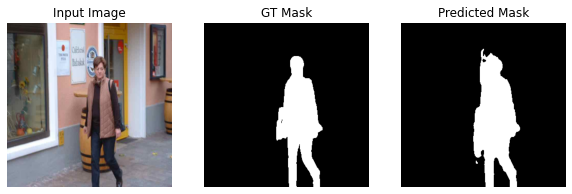

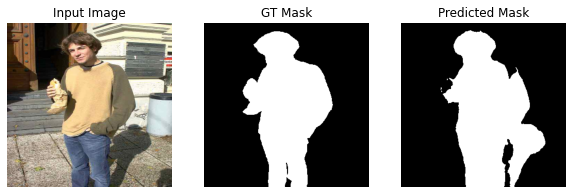

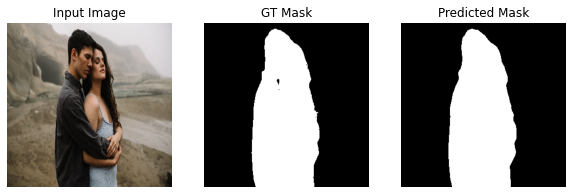

In [21]:
model.load_state_dict(torch.load("/content/best_model.pt"))

for idx, batch in enumerate(validloader):

  images, masks = batch
  image, mask = images[0], masks[0]
  logits_mask = model(image.to(DEVICE).unsqueeze(0))
  pred_mask = torch.sigmoid(logits_mask)
  pred_mask = (pred_mask > 0.5) * 1.
  show_image(image.squeeze(0), mask, pred_mask.detach().cpu().squeeze(0))

  if idx == 2:
    break